# Quantization

If you recall the introduction to this chapter, we saw that digitized audio has two properties: the *sampling rate* (already covered in this chapter), and the *precision*.  This section concerns the *precision* of digital audio, but what exactly does this mean?
To understand this, we'll first need to take a detour to see how computers represent numerical data.

## Background: digital computers and integers

These days, most humans use the Hindu-Arabic (or *decimal*) numeral system to represent numbers.
With decimal digits, we use the ten symbols $0,1,2,\cdots,9$ to encode numbers as combinations of powers of ten (the *base* or *radix* of the system).
For example, a number like $132$ can be expanded out in terms of powers of 10:
$$
132= 1 \cdot 10^2 + 3 \cdot 10^1 + 2 \cdot 10^0.
$$
There's nothing magical about the number 10 here: it was probably chosen to match up with the number of fingers (ahem, *digits*) most people possess.
Any other *base* can work too.

Of course, computers don't have fingers, so they might find decimal to be difficult.
Computers do have logic gates though, which can represent *true* and *false* values, which we can interpret as $1$ and $0$ respectively.
This leads us to *binary* numbers, which only use two symbols to encode numbers as combinations of powers of 2, rather than combinations of powers of 10.

In our example above, the number $132$ could be represented as
\begin{align*}
132 &= 1 \cdot 128 + 0 \cdot 64 + 0 \cdot 32 + 0 \cdot 16 + 0 \cdot 8 + 1 \cdot 4 + 0 \cdot 2 + 0 \cdot 1\\
&= 1 \cdot 2^7 + 0 \cdot 2^6 + 0 \cdot 2^5 + 0 \cdot 2^4 + 0 \cdot 2^3 + 1 \cdot 2^2 + 0 \cdot 2^1 + 0 \cdot 2^0,
\end{align*}
or, more compactly, as $10000100_2$ (where the subscript lets us know we're in binary).


For various technical reasons, computers don't generally support arbitrarily large numbers.
Instead, integers come in a few different "sizes" depending on how many bits we'll need: usually, 8, 16, 32, or 64 bits.
The example above is an *8-bit number*, but it could just as easily have been written in 16-, 32- or 64-bit representation by using leading zeros:
$0000000010000100_2$ for 132 in 16-bit form.

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cycler
import matplotlib.path as path
import matplotlib.patches as patches
from matplotlib.transforms import Bbox
import warnings
warnings.simplefilter('ignore')

from matplotlib.animation import FuncAnimation
import matplotlib.style
matplotlib.style.use('bauhaus')

np.random.seed(20200101)

colors = [_['color'] for _ in list(matplotlib.rcParams['axes.prop_cycle'])]

### Negative numbers

An $n$-bit number can represent $2^n$ distinct numbers, but *which numbers*?
We can interpret the bit representation as the numbers $0, 1, \cdots, 2^n-1$, but this doesn't provide an obvious way to represent *negative numbers*.

There's an elegant solution to this problem if we imagine arranging binary numbers around a circle, as illustrated below for 3-bit numbers.
We can think of counter-clockwise movement as *incrementing* by one, and clockwise movement as *decrementing* by one.
In this view, the numbers beginning with 1 can be seen as negative numbers: $111 = -1, 110 = -2, \dots$, and the numbers beginning with 0 are the positive numbers as discussed above.
It's beyond our scope here, but this representation of integers, known as [two's complement](https://en.wikipedia.org/wiki/Two%27s_complement), has many nice properties, and is implemented by almost every modern computer for doing integer arithmetic.

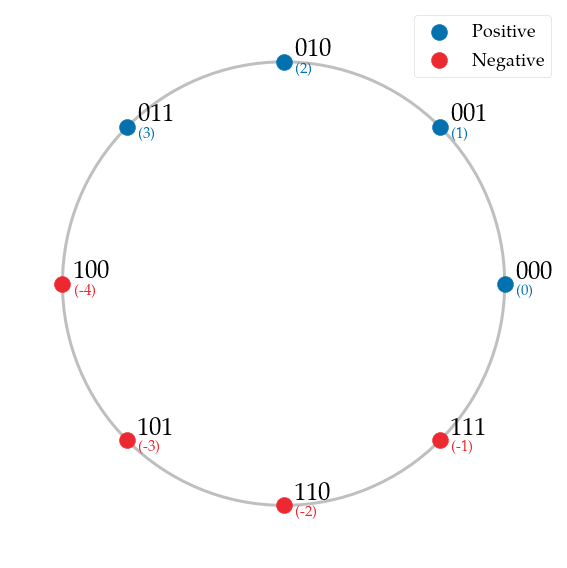

In [3]:
fig = plt.figure()

ax = plt.gca()

angles = np.linspace(0, 2 * np.pi, num=8, endpoint=False)
circ = patches.Ellipse((0, 0), 2, 2, edgecolor='k', linewidth=3, alpha=0.25, fill=False, zorder=-1)
ax.scatter(np.cos(angles[:4]), np.sin(angles[:4]), color=colors[0], label='Positive')
ax.scatter(np.cos(angles[4:]), np.sin(angles[4:]), color=colors[1], label='Negative')
ax.legend(loc='upper right')

for i in range(8):
    ax.text(np.cos(angles[i]) + 0.05, np.sin(angles[i]) + 0.025, '{:03b}'.format(i), size=25)
    if i < 4:
        ax.text(np.cos(angles[i]) + 0.05, np.sin(angles[i]) - 0.05, '({:d})'.format(i), size=15, color=colors[0])
    else:
        ax.text(np.cos(angles[i]) + 0.05, np.sin(angles[i]) - 0.05, '(-{:d})'.format(8-i), size=15, color=colors[1])
        
ax.add_patch(circ)
ax.axis('off')
ax.set_xlim([-1.25, 1.25])
ax.set_ylim([-1.25, 1.25]);
ax.set_xticks([])
ax.set_yticks([]);

To summarize, an $n$-bit two's-complement integer can represent $2^{n-1}$ distinct positive numbers ($0, 1, \dots, 2^{n-1}-1$), and $2^{n-1}$ distinct negative numbers ($-1, -2, \dots, -2^{n-1}$).
For example, an 8-bit number can take $2^8 = 256$ distinct values: $-128, -127, \dots, -2, -1, 0, 1, 2, \dots, 127$.

This is a relatively minor detail in the bigger picture of digital signals, but it can help to understand why quantized signals look the way they do (as illustrated below).

## Defining precision and quantization

**Precision**, also known as **bit depth**, refers to how many *bits* are used to represent each sample in a digital signal.
While we typically think of signals as taking on continuous real values, computers **quantize** these values to be drawn from a fixed, finite set of numbers.

High precision means that we have more distinct values, and can therefore faithfully represent smaller differences and get a more accurate representation of the underlying continuous signal.
However, doing so comes at a cost: higher precision means we're storing and transmitting more data.
There's a tradeoff to be made between storage cost and the perceptual fidelity of the quantized signal.
Investigating this thoroughly is beyond the scope of this text, but interested readers are encouraged to look into *perceptual coding* and *lossy audio compression* to learn more.

# The effects of quantization

The animation below illustrates the effects of varying levels of quantization on samples from a continuous waveform.
High precision values (16-bit) provide a good approximation to the original wave, but this approximation deteriorates as we reduce the precision.
In the extreme case (1-bit quantization), each sample can take only one of two values (-1 or 0), which results in a highly distorted signal.

In [4]:
## This function is defined, but hidden here, since we use it for the animation.
# We'll redefine it inline of the text when it's appropriate to do so.
def quantize(x, n_bits):
    
    # Specify our quantization bins: 
    #   2^n_bits values, evenly (linearly) spaced 
    # between the min and max of the input x
    bins = np.linspace(x.min(), x.max(), 
                          num=2**n_bits, 
                          endpoint=False)
    
    # Quantize x
    return np.digitize(x, bins)

In [5]:
%%capture
# Animations for changing quantization levels

frame_rate = 25
t_high = np.linspace(0, 1, num=1000, endpoint=False)
freq = 2
cont_wave = np.cos(2 * np.pi * freq * t_high)

t_samp = np.linspace(0, 1, num=50, endpoint=False)
samp_inf = np.cos(2 * np.pi * freq * t_samp)
n_frames = 18 * frame_rate

samp_16 = (quantize(samp_inf, 16) - 2**15 -1) * 2.0**(-15)
samp_8 = (quantize(samp_inf, 8) - 2**7-1) * 2.0**(-7)
samp_4 = (quantize(samp_inf, 4) - 2**3-1) * 2.0**(-3)
samp_2 = (quantize(samp_inf, 2) - 2**1-1) * 2.0**(-1)
samp_1 = (quantize(samp_inf, 1) - 2**0-1) * 2.0**(0)

samp_wave = samp_inf

fig = plt.figure(figsize=(8, 4))

ax1 = fig.gca()
ax1.plot(t_high, cont_wave, color='k', alpha=0.25)
sample_plot = ax1.plot(t_samp, samp_wave, color=colors[1], alpha=0.95, marker='.', linestyle='', label='No quantization')[0]

ax1.tick_params(labelbottom=False)
legs = [ax1.legend(loc='lower right')]
ax1.set_ylim([-1.05, 1.05])
ax1.set_yticks([])
ax1.set_xticks([])

def init():
    return sample_plot, legs[0]

def animate(time):
    # 0->2   inf
    # 2->3   inf->16
    # 3->5   16
    # 5->6   16->8
    # 6->8   8
    # 8->9   8->4
    # 9->11  4
    # 11->12 4->2
    # 12->14 2
    # 14->15 2->1
    # 15->17 1
    # 17->18 1->inf
    
    #samp_wave.set_data(t, A_schedule[i] * plain_wave)
    #samp_wave.set_label('$A={:.02f}$'.format(A_schedule[i]))
    
    if time == 0:
        sample_plot.set_data(t_samp, samp_inf)
        sample_plot.set_label('No quantization')
    elif 2 <= time <= 3:
        #alpha = (time - 2)**2
        alpha = (time - 2)**0.5
        sample_plot.set_data(t_samp, (1 - alpha) * samp_inf + alpha * samp_16)
        sample_plot.set_label('16-bit')
    elif 5 <= time <= 6:
        #alpha = (time - 5)**2
        alpha = (time - 5)**0.5
        sample_plot.set_data(t_samp, (1 - alpha) * samp_16 + alpha * samp_8)
        sample_plot.set_label('8-bit')
    elif 8 <= time <= 9:
        #alpha = (time - 8)**2
        alpha = (time - 8)**0.5
        sample_plot.set_data(t_samp, (1 - alpha) * samp_8 + alpha * samp_4)
        sample_plot.set_label('4-bit')
    elif 11 <= time <= 12:
        #alpha = (time - 11)**2
        alpha = (time - 11)**0.5
        sample_plot.set_data(t_samp, (1 - alpha) * samp_4 + alpha * samp_2)
        sample_plot.set_label('2-bit')
    elif 14 <= time <= 15:
        #alpha = (time - 14)**2
        alpha = (time - 14)**0.5
        sample_plot.set_data(t_samp, (1 - alpha) * samp_2 + alpha * samp_1)
        sample_plot.set_label('1-bit')
    elif 17 <= time:
        #alpha = (time - 17)**2
        alpha = (time - 17)**0.5
        sample_plot.set_data(t_samp, (1 - alpha) * samp_1 + alpha * samp_inf)
        sample_plot.set_label('No quantization')
    legs[0].texts[0].set_text(sample_plot.get_label())
    return sample_plot, legs[0]

animation = FuncAnimation(fig, animate, init_func=init,
                               frames=np.arange(n_frames, dtype=float) / frame_rate,
                               interval=1000/frame_rate, blit=True)

In [6]:
animation

## But what does it sound like?

We can simulate quantization numerically by defining a ``quantize`` function as below.
We'll then be able to synthesize a pure tone, and hear how it sounds when quantized to varying bit depths.

**Warning**: the lower bit depths can sound quite harsh.

In [7]:
import numpy as np
from IPython.display import display, Audio

def quantize(x, n_bits):
    '''Quantize an array to a desired bit depth
    
    Parameters
    ----------
    x : np.ndarray
        The data to quantize
        
    n_bits : integer > 0
        The number of bits to use per sample
        
    Returns
    -------
    x_quantize : np.ndarray
        x reduced to the specified bit depth
    '''
    
    # Specify our quantization bins: 
    #   2^n_bits values, evenly (linearly) spaced 
    # between the min and max of the input x
    bins = np.linspace(x.min(), x.max(), 
                          num=2**n_bits, 
                          endpoint=False)
    
    # Quantize x
    return np.digitize(x, bins)


# We'll make a 1-second example tone at 220 Hz
duration = 1.0
fs = 11025
freq = 220

# Our sample times
t = np.linspace(0, duration,
                   num=int(duration * fs),
                   endpoint=False)

# The continuous signal
x = np.cos(2 * np.pi * freq * t)

print('Original signal')
display(Audio(data=x, rate=fs))

# And play the audio at each bit depth
for bits in [16, 8, 4, 2, 1]:
    print('{}-bit'.format(bits))
    display(Audio(data=quantize(x, bits), rate=fs))

Original signal


16-bit


8-bit


4-bit


2-bit


1-bit


# Quantization in practice

By now, we've seen how quantization works, what it looks like visually, and how it sounds.
But how do we use this information practically?

16-bit quantization (65536 distinct values) is the standard for compct disc-quality audio, and it suffices for most practical applications.
Although audio data is stored this way (e.g., in `.wav` files), we don't usually worry about quantization when *processing* audio in a computer.
Instead, the most common pattern is to convert audio signals to *floating point* numbers (which are better approximations to continuous-valued real numbers), do whatever analysis or filtering we want to do, and then only quantize again when we need to save or play back audio at the end.
Usually this happens behind the scenes, and you don't need to worry about it directly.